In [ ]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import extended_model as em
import aguilera_model as am

In [ ]:
london = np.loadtxt("london_map_array.txt")
london = np.where(london == 0,-1,london)

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [ ]:
# NEED TO CHANGE SO I CAN HAVE CUSTOM PROPORTIONS FOR ETHNICITY
def initialize_affluence_and_house_grids(city_grid, affluence_levels, p):
    """
    Initializes affluence and house grids based on the generated city grid.
    Houses receive random affluence levels, while roads remain at 0.
    """
    rho = 0.3
    n, m = city_grid.shape
    noise = np.random.rand(n, m)
    affluence_grid = np.zeros((n, m), dtype=float)
    house_grid = np.zeros((n, m), dtype=float)
    politics_grid = np.zeros((n, m), dtype = float)
    continuous_political_grid = np.zeros((n, m), dtype = float)
    religion_grid = np.zeros((n, m), dtype = float)
    ethnicity_grid = np.zeros((n, m), dtype = float)
    for i in range(n):
        for j in range(m):
            if city_grid[i, j] == 1:  # 1 is our value for houses
                affluence_grid[i, j] = np.random.choice(
                    [affluence_levels["rich"], affluence_levels["middle"], affluence_levels["poor"]],
                    p=p
                )
                continuous_political_grid[i,j] = rho * affluence_grid[i,j] + (1- rho) * noise[i,j]
                if continuous_political_grid[i,j] < 0.33:
                    politics_grid[i,j] = 0
                elif 0.33 <= continuous_political_grid[i,j] < 0.66:
                    politics_grid[i,j] = 0.5
                else:
                    politics_grid[i,j] = 1
                religion_grid[i,j] = np.random.choice([1,0])
                ethnicity_grid[i, j] = np.random.choice([1,2,3,4,5,6])
                house_grid[i, j] = np.random.uniform(0,1)  # Mark as a house
            elif city_grid[i, j] == -1: 
                continuous_political_grid[i, j] = -1
                affluence_grid[i, j] = -1  # give as road in affluence grid
                house_grid[i,j] = -1
                politics_grid[i,j] = -1
                religion_grid[i,j] = -1
                ethnicity_grid[i,j] = -1

    return affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid


In [36]:
def plot_grid(house_grid, step):
    """
    Plot the current state of the grid.
    """
    plt.imshow(house_grid, cmap='plasma', origin='upper')
    plt.title(f'Step {step}')
    plt.colorbar(label='House Value')
    plt.show()
    plt.pause(0.5)
    clear_output(wait=True)
    display(plt.gcf())

In [ ]:
n = 100
lambda_ = 0.65
r = 2
branch_prob = 0.3
p = [0.1, 0.6, 0.3] # CHANGE
affluence_levels = {
    "rich": 0.7,
    "middle": 0.5,
    "poor": 0.3
}

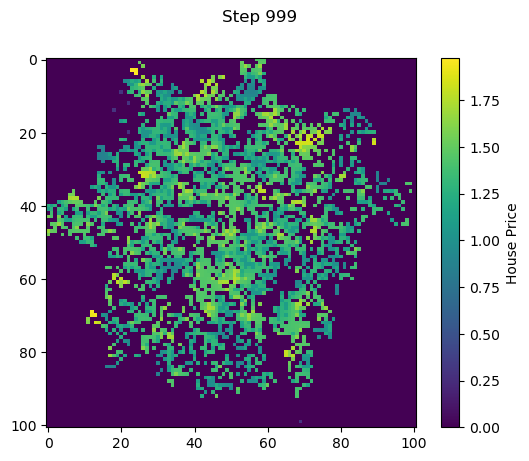

In [ ]:
# Simulation parameters
n_steps = 1000
affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid = initialize_affluence_and_house_grids(london, affluence_levels, p)

fig, ax = plt.subplots()
fig.suptitle('Step 0')
img = plt.imshow(house_grid, cmap='viridis',vmin=0, vmax=3.5)

cbar = fig.colorbar(img, ax=ax)
cbar.set_label('House Price')


# Simulation loop
for step in range(n_steps):
    # Update house values
    house_grid = am.calculate_new_house_values_conv(house_grid, affluence_grid, r, lambda_, calc_num_neighbours = True)
    
    # Propose random move - several in each step
    for i in range(1000):
        em.make_swap(affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid, )

    img.set_array(house_grid)
    img.set_clim(vmax = np.max(house_grid))
    fig.suptitle(f"Step {step}")
    plt.pause(0.001)
    clear_output(wait=True)
    display(fig)
    

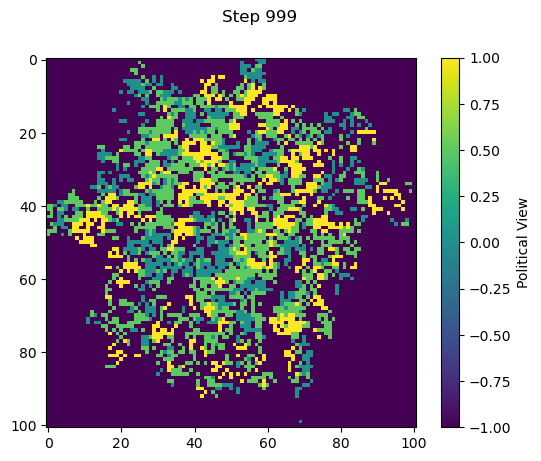

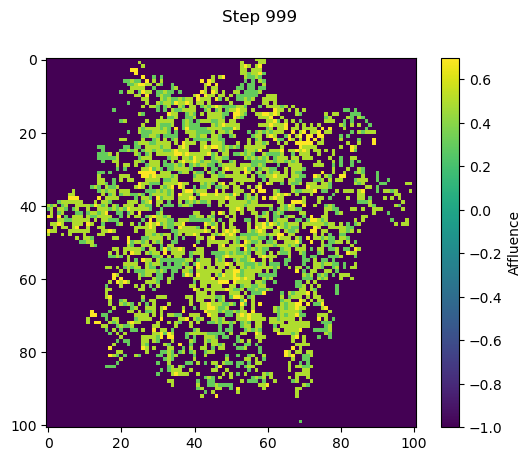

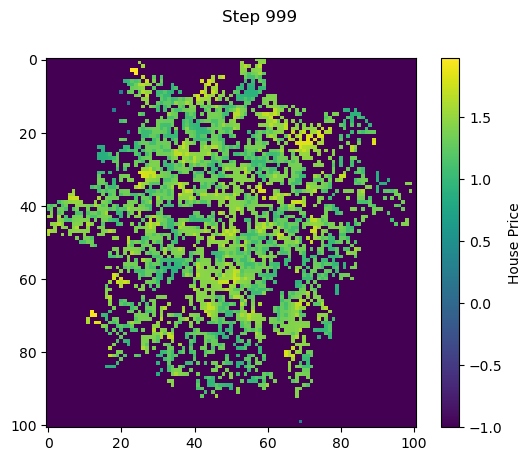

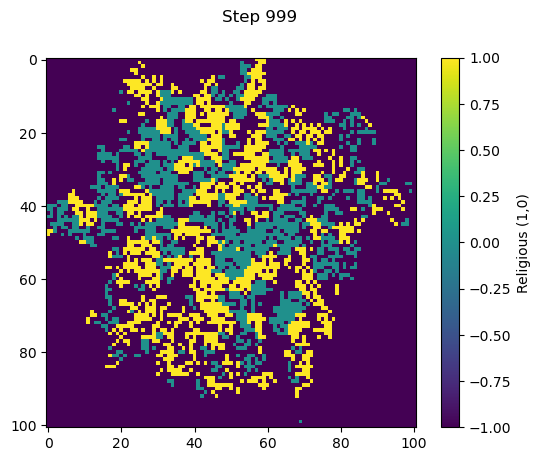

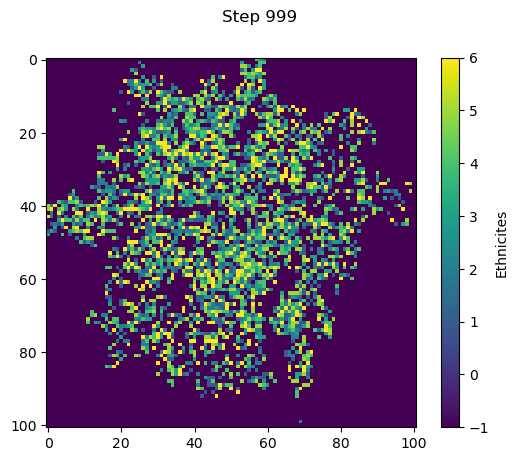

In [53]:
img.set_array(politics_grid)
img.set_clim(vmin = -1, vmax = np.max(politics_grid))
cbar.set_label('Political View')
display(fig)
img.set_array(affluence_grid)
img.set_clim(vmin = np.min(affluence_grid), vmax = np.max(affluence_grid))
cbar.set_label('Affluence')
display(fig)
img.set_array(house_grid)
img.set_clim(vmax = np.max(house_grid))
cbar.set_label('House Price')
display(fig)
img.set_array(religion_grid)
img.set_clim(vmin = -1, vmax = np.max(religion_grid))
cbar.set_label('Religious (1,0)')
display(fig)
img.set_array(ethnicity_grid)
img.set_clim(vmin =-1, vmax = np.max(ethnicity_grid))
cbar.set_label('Ethnicites')
display(fig)

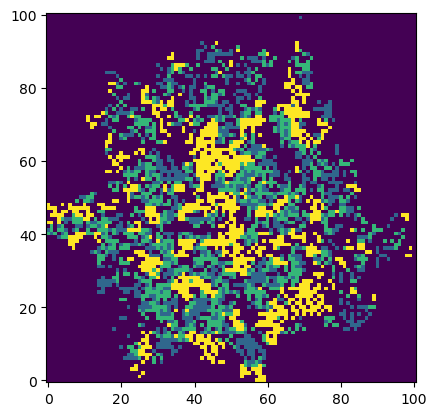

In [54]:
hp_array = house_grid[house_grid > -1]
percentile_33 = np.percentile(hp_array, 33.3)
percentile_67 = np.percentile(hp_array, 66.7)

hp_matrix_binned = np.ones_like(house_grid)
m,n = hp_matrix_binned.shape
for i in range(m):
    for j in range(n):
        price = house_grid[i,j]
        if price != -1:
            if price <= percentile_33:
                hp_matrix_binned[i,j] = 2
            elif price <= percentile_67:
                hp_matrix_binned[i,j] = 3
            else:
                hp_matrix_binned[i,j] = 4


plt.imshow(hp_matrix_binned, origin = 'lower')
plt.show()

In [55]:
import spatial_seg as spseg

In [56]:
with open("london_exp_entropy.txt") as f:
    expected_entropy = float(f.read())

# Calc London segregation index
london_sp_seg = spseg.spatial_segregation(hp_matrix_binned, expected_entropy)
london_sp_seg

0.08067353885288986